<a href="https://colab.research.google.com/github/Sirayus/colab-notebook/blob/main/How_release_date_related_to_profit_imdb_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Dataset

### Import Library and Data

In [8]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [9]:
!pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sirayushongsanandana","key":"2252546465b64b9af446db26cb4c2b19"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d stefanoleone992/imdb-extensive-dataset

imdb-extensive-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
!ls

 files			     'kaggle (1).json'	 sample_data
 imdb-extensive-dataset.zip   kaggle.json


In [13]:
import zipfile
zip_ref = zipfile.ZipFile("imdb-extensive-dataset.zip", "r") # Don't forget to change file name to zip
zip_ref.extractall("files")
zip_ref.close()

In [14]:
movies = pd.read_csv('/content/files/IMDb movies.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Take a sneak peek

In [15]:
# movies.info()

In [16]:
# movies.describe(include=['int64', 'float64', 'object'])

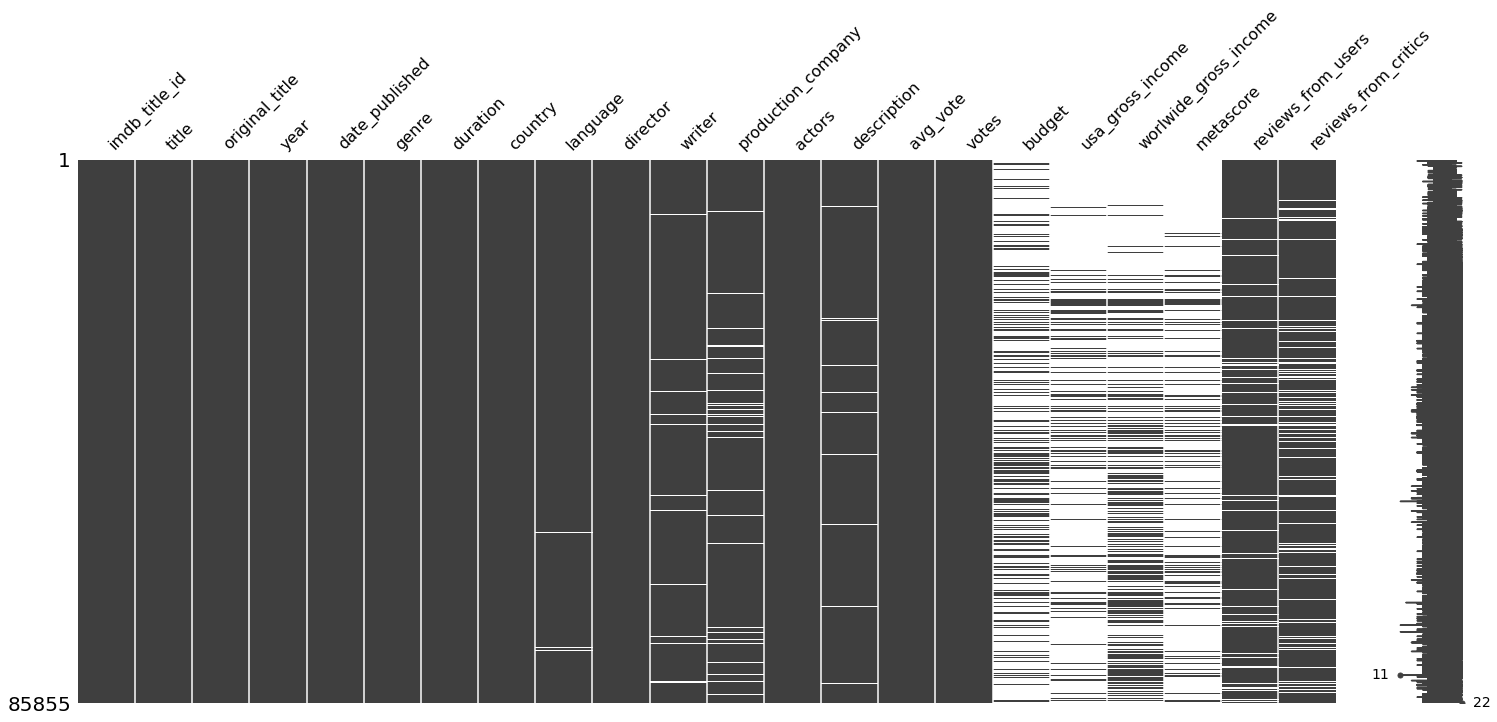

In [17]:
msno.matrix(movies)

### Explore data through visualization

In [18]:
# plt.figure(figsize=(8,8))
# sns.pairplot(data=movies)

There seems to be postive correlation between ang_vote(imdb score) and metascore

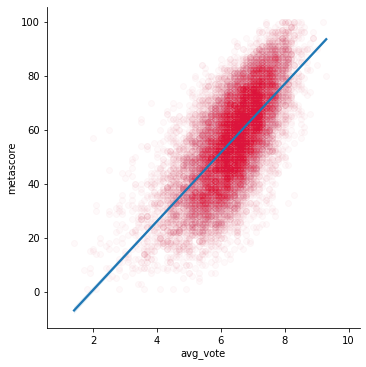

In [19]:
sns.lmplot(data=movies, x='avg_vote', y='metascore', scatter_kws={'alpha':0.025,'color': 'crimson'})

Distribution of IMDB score and metascore

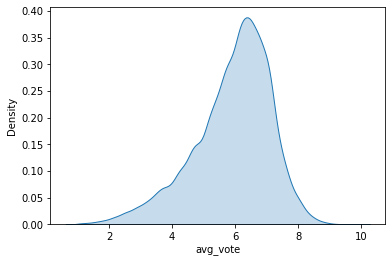

In [20]:
sns.kdeplot(movies['avg_vote']
            ,shade = True
            )

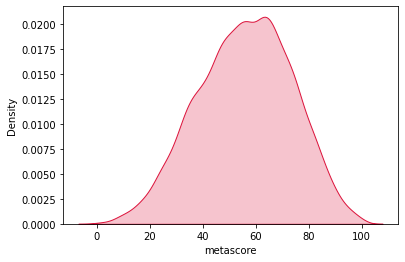

In [21]:
sns.kdeplot(movies['metascore']
            ,shade = True
            , color='crimson')

In [22]:
print(movies['avg_vote'].mean(), movies['avg_vote'].median())
print(movies['metascore'].mean(), movies['metascore'].median())

5.898655873274613 6.1
55.89688087185269 57.0


# Question

**1. How release date affect gross income and profit(USA and worldwide)?
    - Month
    - Week
    - Day
    - Day of week
2. How release date affect IMDB score and Metascore? income and profit? Score affect profitability?
    - Month
    - Week
    - Day
    - Day of week
3. How release date related to genre (and gross income)?
    - Month
    - Week
    - Day
    - Day of week

### Transforming

Correct the spelling from worlwide to worldwide

In [23]:
movies.columns = ['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worldwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics']

In [24]:
# Drop usa gross income to focus only on worldwide income
movies = movies.loc[:, ['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'worldwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics']]

In [25]:
movies.head(2)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,worldwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,7.0,7.0


In [26]:
movies['date_published']

0        1894-10-09
1        1906-12-26
2        1911-08-19
3        1912-11-13
4        1911-03-06
            ...    
85850    2020-01-29
85851    2020-02-13
85852    2019-03-08
85853    2019-03-15
85854    2020-02-05
Name: date_published, Length: 85855, dtype: object

There are some inconsistent needed to be clean. In this case there is this one, 'TV movie 2019'

In [27]:
movies['date_published'] = movies['date_published'].str.replace('TV Movie 2019', '2019-01-01')

Convert data type to datetime and extract part of date

In [28]:
movies['date_published'] = pd.to_datetime(movies['date_published'])
movies['date_published']

0       1894-10-09
1       1906-12-26
2       1911-08-19
3       1912-11-13
4       1911-03-06
           ...    
85850   2020-01-29
85851   2020-02-13
85852   2019-03-08
85853   2019-03-15
85854   2020-02-05
Name: date_published, Length: 85855, dtype: datetime64[ns]

In [29]:
movies['publish_year'] = movies['date_published'].dt.year

In [30]:
movies['publish_month'] = movies['date_published'].dt.month
# .\
# replace({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
#         7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

In [31]:
movies['publish_week'] = movies['date_published'].dt.isocalendar().week

In [32]:
movies['publish_day'] = movies['date_published'].dt.day

In [33]:
movies['publish_dayofweek']= movies['date_published'].dt.dayofweek
# .\
# replace({0:'Mon', 1:'Tue',2:'Wed', 3:'Thu',4:'Fri', 5:'Sat', 6:'Sun'})

Genre column has more than 1 genre in the some entry. So, I split it, by comma, into genre_1 and genre_2 and ignore all the rest.

In [34]:
movies['genre_1'] = movies['genre'].str.split(',', expand=True)[0]
movies['genre_2'] = movies['genre'].str.split(',', expand=True)[1]

Budget and worldwide income column have doolar sign($) in their entry.

In [35]:
clean_df = movies[(movies['budget'].str.contains('\$\s').fillna(False)) & 
#                   (movies['usa_gross_income'].str.contains('\$\s').fillna(False)) &
                 (movies['worldwide_gross_income'].str.contains('\$\s').fillna(False))]
clean_df.loc[:,['budget'
#                 ,'usa_gross_income'
                ,'worldwide_gross_income']]
# msno.matrix(clean_df)
clean_df['budget'] = clean_df['budget'].str.strip('\$\s').astype('float64')
# clean_df['usa_gross_income'] = clean_df['usa_gross_income'].str.strip('\$\s').astype('float64')
clean_df['worldwide_gross_income'] = clean_df['worldwide_gross_income'].str.strip('\$\s').astype('float64')
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9025 entries, 165 to 85756
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   imdb_title_id           9025 non-null   object        
 1   title                   9025 non-null   object        
 2   original_title          9025 non-null   object        
 3   year                    9025 non-null   object        
 4   date_published          9025 non-null   datetime64[ns]
 5   genre                   9025 non-null   object        
 6   duration                9025 non-null   int64         
 7   country                 9024 non-null   object        
 8   language                9000 non-null   object        
 9   director                9024 non-null   object        
 10  writer                  9006 non-null   object        
 11  production_company      8953 non-null   object        
 12  actors                  9023 non-null   objec

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Data are missing a lot during this process but it necessary because the need to focus on gross income. So, if there are null value, it should be drop out. Budget column contains various currency. So, I decided to use only US dollars.

In [36]:
# percent revenue
# clean_df['usa_percent_revenue'] = clean_df['usa_gross_income']/clean_df['budget']*100
clean_df['ww_percent_revenue'] = clean_df['worldwide_gross_income']/clean_df['budget']*100
clean_df['ww_percent_revenue']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


165        48.950000
245      1147.959125
251        10.766400
348         3.200285
415         2.916143
            ...     
85477       2.091500
85530     101.637684
85592       1.197200
85740     114.012700
85756      14.269083
Name: ww_percent_revenue, Length: 9025, dtype: float64

In [37]:
# profit
# clean_df['usa_profit'] = clean_df['usa_gross_income'] - clean_df['budget']
clean_df['ww_profit'] = clean_df['worldwide_gross_income'] - clean_df['budget']
clean_df['ww_profit']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


165        -9189.0
245      8383673.0
251      -223084.0
348      -339767.0
415      -896084.0
           ...    
85477    -195817.0
85530      15558.0
85592    -494014.0
85740    1681524.0
85756   -1028771.0
Name: ww_profit, Length: 9025, dtype: float64

In [38]:
# percent profit
# clean_df['usa_percent_profit'] = (clean_df['usa_gross_income'] - clean_df['budget'])/clean_df['budget']*100
clean_df['ww_percent_profit'] = (clean_df['worldwide_gross_income'] - clean_df['budget'])/clean_df['budget']*100
clean_df['ww_percent_profit']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


165       -51.050000
245      1047.959125
251       -89.233600
348       -96.799715
415       -97.083857
            ...     
85477     -97.908500
85530       1.637684
85592     -98.802800
85740      14.012700
85756     -85.730917
Name: ww_percent_profit, Length: 9025, dtype: float64

In [39]:
clean_df['metascore'].fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


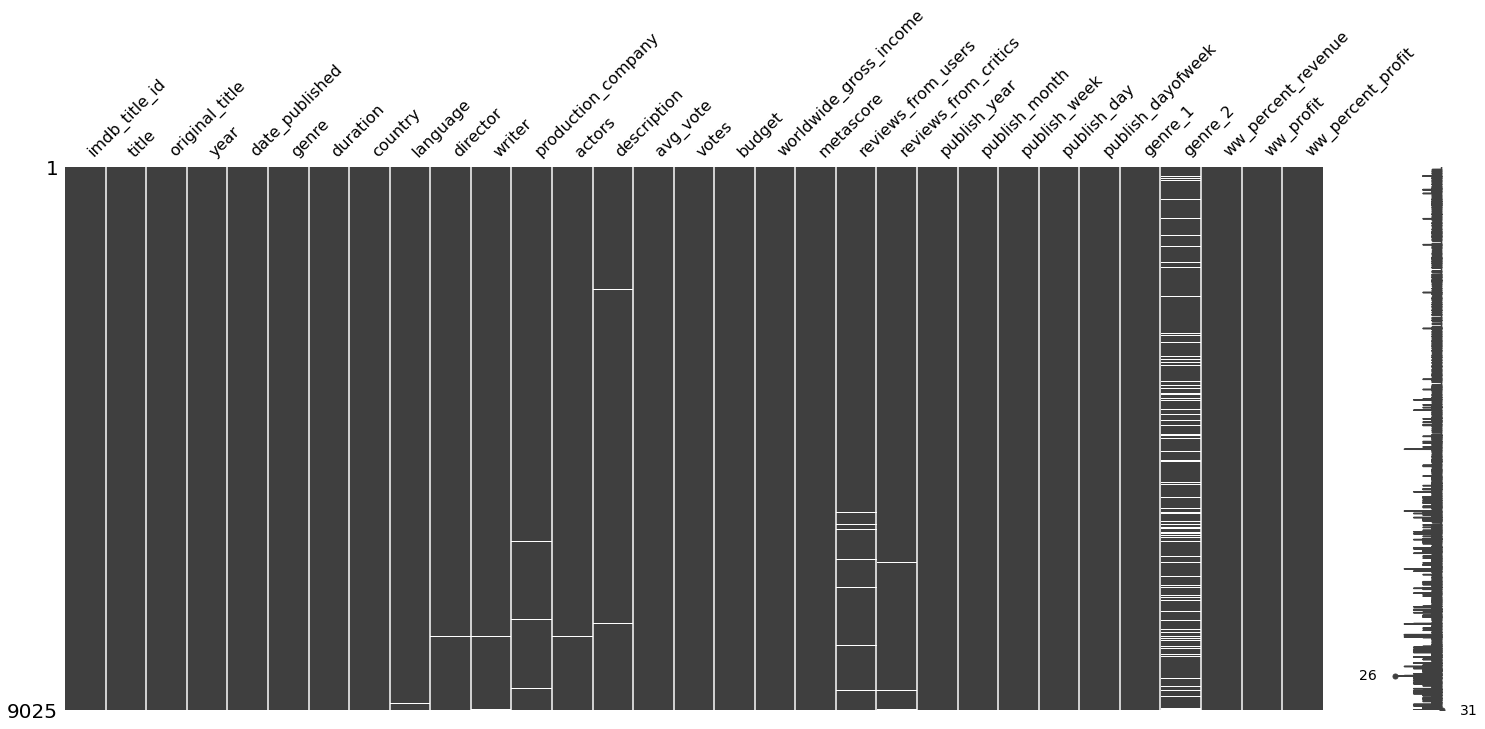

In [40]:
msno.matrix(clean_df)

## 1. How release date affect gross income and profit(USA and worldwide)?

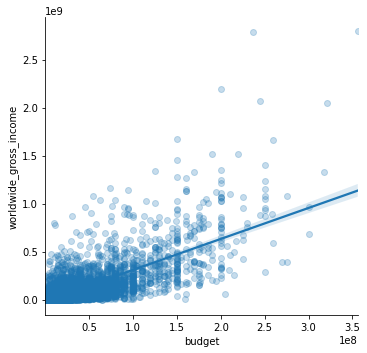

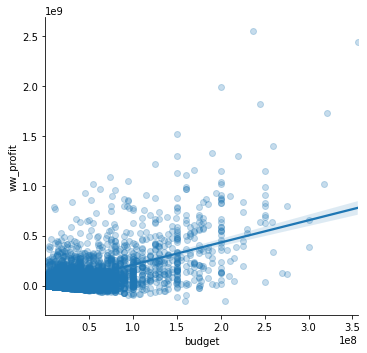

In [41]:
sns.lmplot(data=clean_df, x='budget', y='worldwide_gross_income', height=5, scatter_kws={'alpha':0.25})
sns.lmplot(data=clean_df, x='budget', y='ww_profit', height=5, scatter_kws={'alpha':0.25})

There seems to be positive correlation between film budget and their gross income and profit

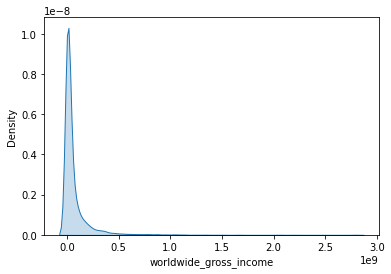

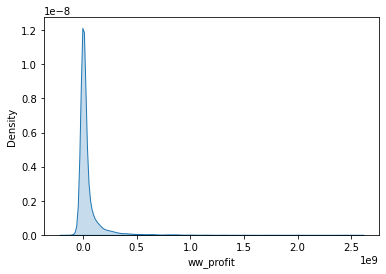

In [42]:
# sns.kdeplot(clean_df['usa_gross_income']
#             ,shade = True
#             )
# plt.show()

sns.kdeplot(clean_df['worldwide_gross_income']
            ,shade = True
            )

plt.show()
# sns.kdeplot(clean_df['usa_profit']
#             ,shade = True
#             )
# plt.show()

sns.kdeplot(clean_df['ww_profit']
            ,shade = True
            )

Distribution is very skewed so Mean value might not be the best statistics to use. Use Median value instead.

In [43]:
# Define function for dual plot
def dual_plot_median(data, group, col1, col2):
    df = data
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(df.groupby(str(group)).agg({str(col1):'median'}), color='steelblue'
             , label=str(col1))
    ax1.tick_params(axis='y', labelcolor='steelblue')

    ax2 = ax1.twinx()
    ax2.plot(df.groupby(str(group)).agg({str(col2):'median'}), color='crimson'
             , label=str(col2))
    ax2.tick_params(axis='y', labelcolor='crimson')
    fig.legend(loc='upper center')

### Publish Year

In [44]:
# dual_plot_median('publish_year', 'budget', 'usa_gross_income')
# dual_plot_median('publish_year', 'budget', 'usa_profit')
# dual_plot_median('publish_year', 'budget', 'usa_percent_profit')

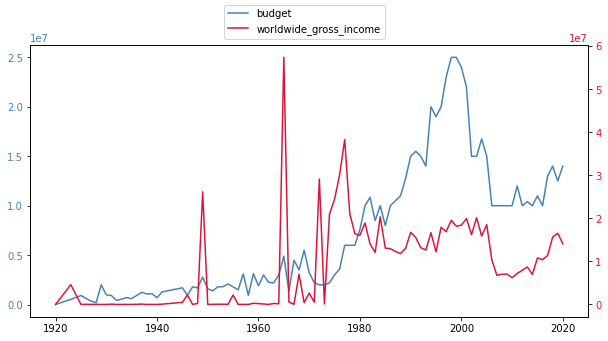

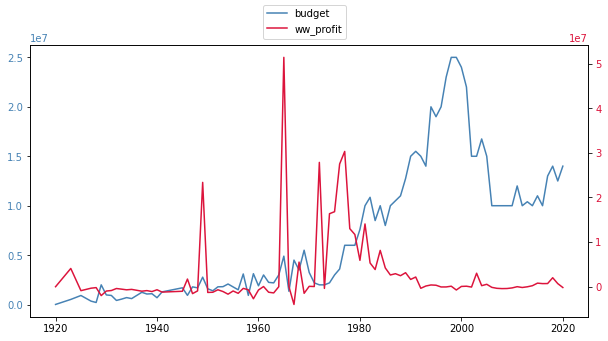

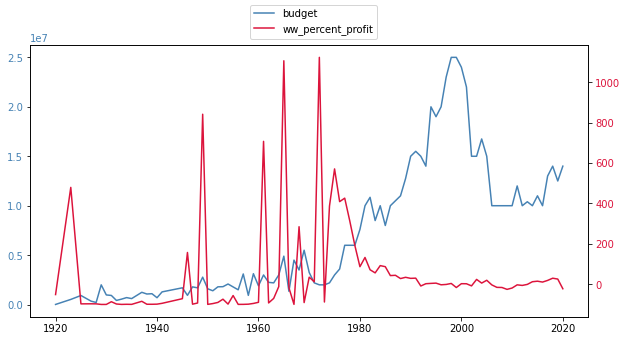

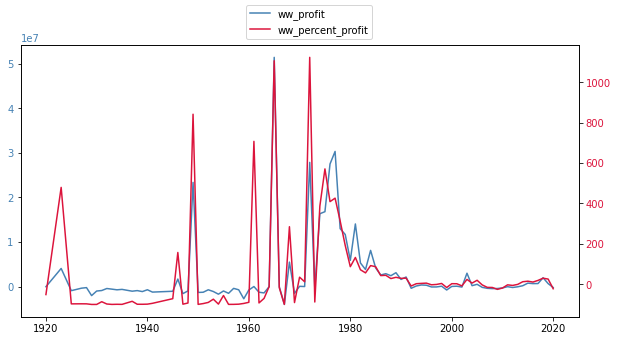

In [45]:
dual_plot_median(clean_df, 'publish_year', 'budget', 'worldwide_gross_income')
dual_plot_median(clean_df, 'publish_year', 'budget', 'ww_profit')
dual_plot_median(clean_df, 'publish_year', 'budget', 'ww_percent_profit')
dual_plot_median(clean_df, 'publish_year', 'ww_profit', 'ww_percent_profit')

Although Median value of budget is rising, median value of profit remains the same level.

### Publish Month

In [46]:
# dual_plot_median('publish_month', 'budget', 'usa_gross_income')
# dual_plot_median('publish_month', 'budget', 'usa_profit')
# dual_plot_median('publish_month', 'budget', 'usa_percent_profit')
# dual_plot_median('publish_month', 'usa_profit', 'usa_percent_profit')

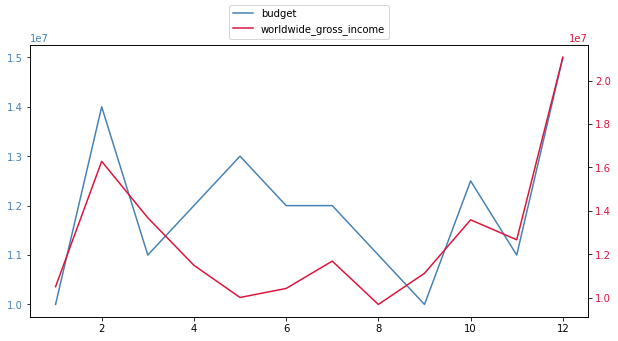

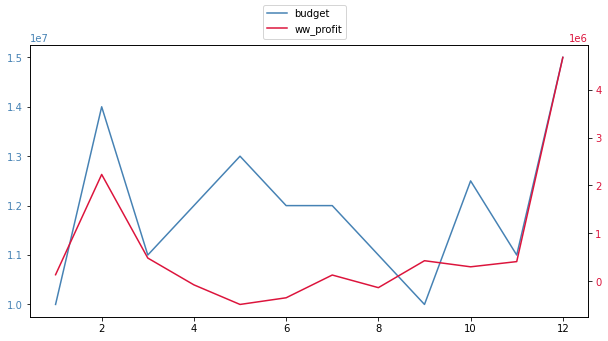

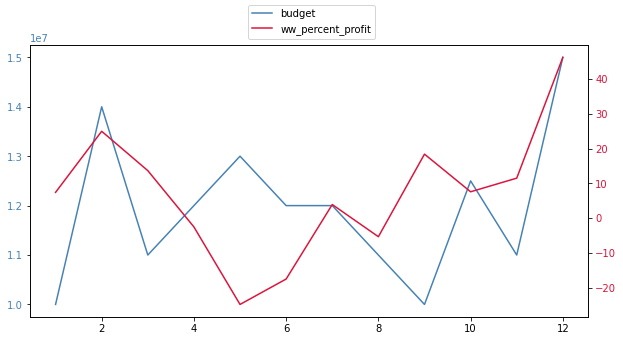

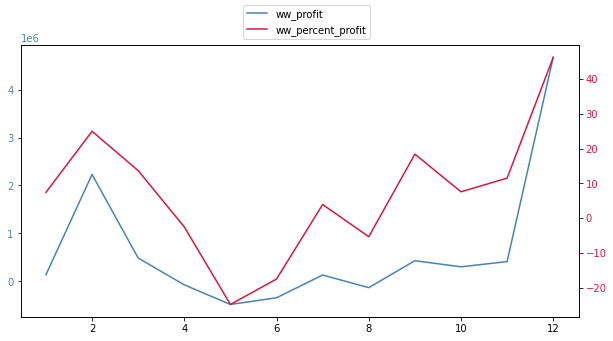

In [47]:
dual_plot_median(clean_df, 'publish_month', 'budget', 'worldwide_gross_income')
dual_plot_median(clean_df, 'publish_month', 'budget', 'ww_profit')
dual_plot_median(clean_df, 'publish_month', 'budget', 'ww_percent_profit')
dual_plot_median(clean_df, 'publish_month', 'ww_profit', 'ww_percent_profit')

In [48]:
clean_df.groupby('publish_month').agg({'budget':'median'}).sort_values(by='budget', ascending=False).head(5)

,budget
publish_month,
12,15000000.0
2,14000000.0
5,13000000.0
10,12500000.0
4,12000000.0


In [49]:
clean_df.groupby('publish_month').agg({'worldwide_gross_income':'median'})\
.sort_values(by='worldwide_gross_income', ascending=False).head(5)

,worldwide_gross_income
publish_month,
12,21070527.0
2,16278747.0
3,13678913.0
10,13584382.5
11,12665974.0


In [50]:
clean_df.groupby('publish_month').agg({'ww_profit':'median'}).sort_values(by='ww_profit', ascending=False).head(5)

,ww_profit
publish_month,
12,4674194.5
2,2230043.5
3,485341.0
9,429687.0
11,411112.0


In [51]:
clean_df.groupby('publish_month').agg({'ww_percent_profit':'median'}).sort_values(by='ww_percent_profit', ascending=False).head(5)

,ww_percent_profit
publish_month,
12,46.258233
2,24.982233
9,18.403000
3,13.655640
11,11.489573


* Films with high budget tend to release in December, February, May, and October respectively
* Films with high profit tend to release in December and February
* Films wiith high percent profit tend to release in December, February, September, and November respectively

### Publish Week

In [52]:
# dual_plot_median('publish_week', 'budget', 'usa_gross_income')
# dual_plot_median('publish_week', 'budget', 'usa_profit')
# dual_plot_median('publish_week', 'budget', 'usa_percent_profit')
# dual_plot_median('publish_week', 'usa_profit', 'usa_percent_profit')

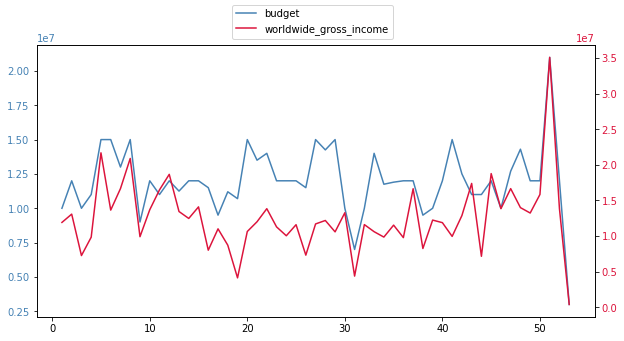

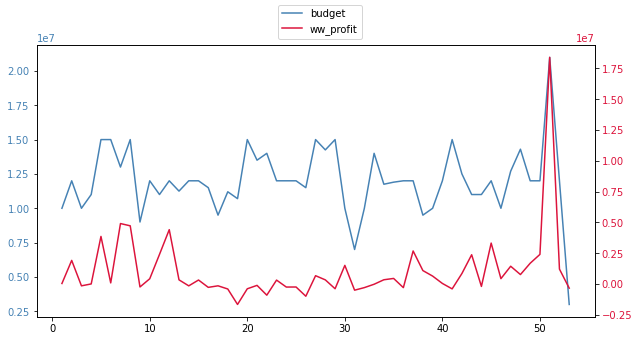

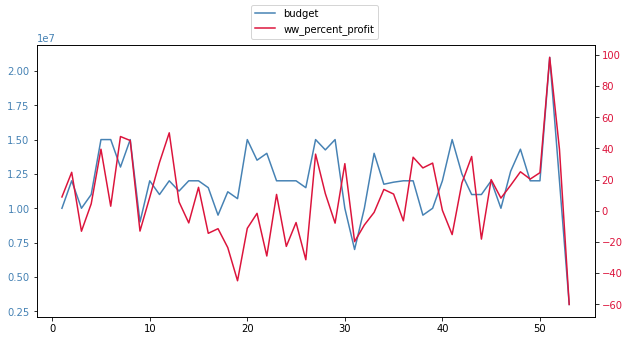

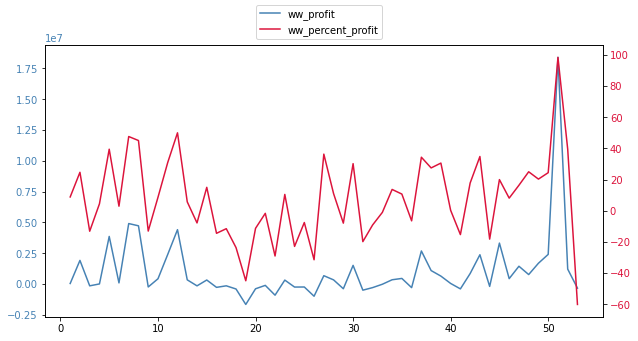

In [53]:
dual_plot_median(clean_df, 'publish_week', 'budget', 'worldwide_gross_income')
dual_plot_median(clean_df, 'publish_week', 'budget', 'ww_profit')
dual_plot_median(clean_df, 'publish_week', 'budget', 'ww_percent_profit')
dual_plot_median(clean_df, 'publish_week', 'ww_profit', 'ww_percent_profit')

In [54]:
clean_df.groupby('publish_week').agg({'budget':'median'}).sort_values(by='budget', ascending=False).head(5)

,budget
publish_week,
51,20985000.0
27,15000000.0
20,15000000.0
41,15000000.0
5,15000000.0


In [55]:
clean_df.groupby('publish_week').agg({'worldwide_gross_income':'median'})\
.sort_values(by='worldwide_gross_income', ascending=False).head(5)

,worldwide_gross_income
publish_week,
51,35082398.0
5,21672284.0
8,20880418.5
45,18753438.0
12,18647791.0


In [56]:
clean_df.groupby('publish_week').agg({'ww_profit':'median'}).sort_values(by='ww_profit', ascending=False).head(5)

,ww_profit
publish_week,
51,18400820.0
7,4910168.0
8,4726578.5
12,4413981.0
5,3864519.0


In [57]:
clean_df.groupby('publish_month').agg({'ww_percent_profit':'median'}).sort_values(by='ww_percent_profit', ascending=False).head(5)

,ww_percent_profit
publish_month,
12,46.258233
2,24.982233
9,18.403000
3,13.655640
11,11.489573


* Films with high budget tend to release in week number 51, 27, and 20 respectively.
* Films with high profit tend to release in week number 51, 7, and 8 respectively.
* Films wiith high percent profit tend to release in week number 12, 2, and 9 respectively.

### Publish Day

In [58]:
# dual_plot_median('publish_day', 'budget', 'usa_gross_income')
# dual_plot_median('publish_day', 'budget', 'usa_profit')
# dual_plot_median('publish_day', 'budget', 'usa_percent_profit')
# dual_plot_median('publish_day', 'usa_profit', 'usa_percent_profit')

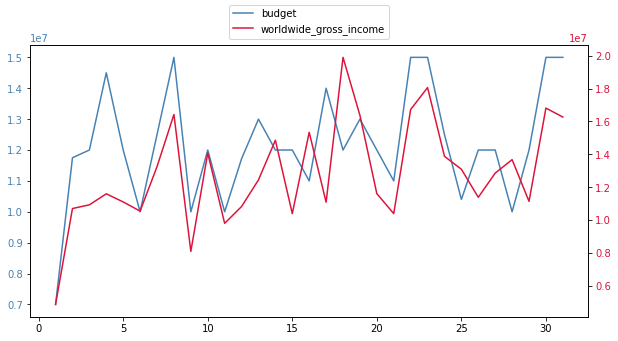

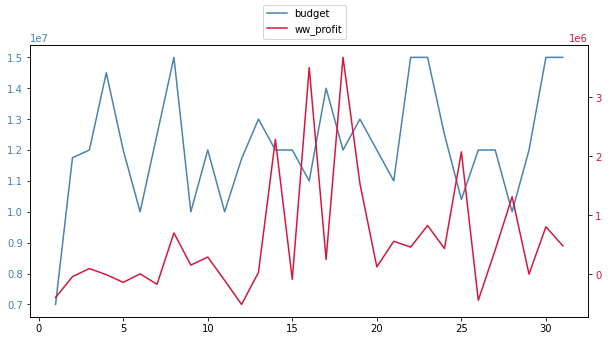

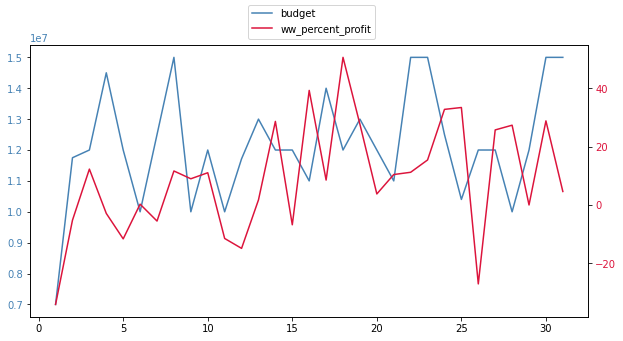

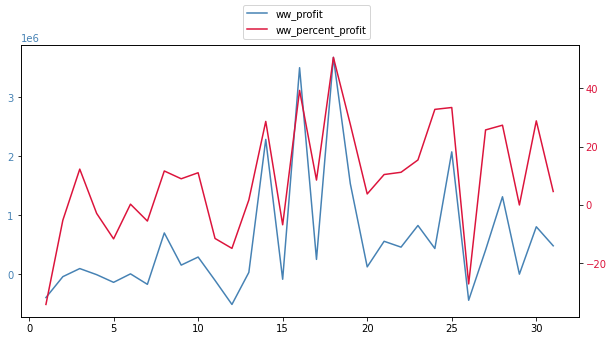

In [59]:
dual_plot_median(clean_df, 'publish_day', 'budget', 'worldwide_gross_income')
dual_plot_median(clean_df, 'publish_day', 'budget', 'ww_profit')
dual_plot_median(clean_df, 'publish_day', 'budget', 'ww_percent_profit')
dual_plot_median(clean_df, 'publish_day', 'ww_profit', 'ww_percent_profit')

In [60]:
clean_df.groupby('publish_day').agg({'budget':'median'}).sort_values(by='budget', ascending=False).head(5)

,budget
publish_day,
31,15000000.0
30,15000000.0
22,15000000.0
8,15000000.0
23,15000000.0


In [61]:
clean_df.groupby('publish_day').agg({'worldwide_gross_income':'median'})\
.sort_values(by='worldwide_gross_income', ascending=False).head(5)

,worldwide_gross_income
publish_day,
18,19905359.0
23,18065657.5
30,16816532.5
22,16729733.0
8,16426471.0


In [62]:
clean_df.groupby('publish_day').agg({'ww_profit':'median'}).sort_values(by='ww_profit', ascending=False).head(5)

,ww_profit
publish_day,
18,3674699.0
16,3499259.5
14,2283970.0
25,2072758.0
19,1534524.5


In [63]:
clean_df.groupby('publish_day').agg({'ww_percent_profit':'median'}).sort_values(by='ww_percent_profit', ascending=False).head(5)

,ww_percent_profit
publish_day,
18,50.564333
16,39.241564
25,33.386333
24,32.745000
30,28.808633


* Films with high budget tend to release on date 31, 30, and 22 respectively.
* Films with high profit tend to release on date 18, 16, and 14 respectively.
* Films wiith high percent profit tend to release on date 18, 16, and 25 respectively.

### Publish Day of Week

In [64]:
# dual_plot_median('publish_dayofweek', 'budget', 'usa_gross_income')
# dual_plot_median('publish_dayofweek', 'budget', 'usa_profit')
# dual_plot_median('publish_dayofweek', 'budget', 'usa_percent_profit')
# dual_plot_median('publish_dayofweek', 'usa_profit', 'usa_percent_profit')

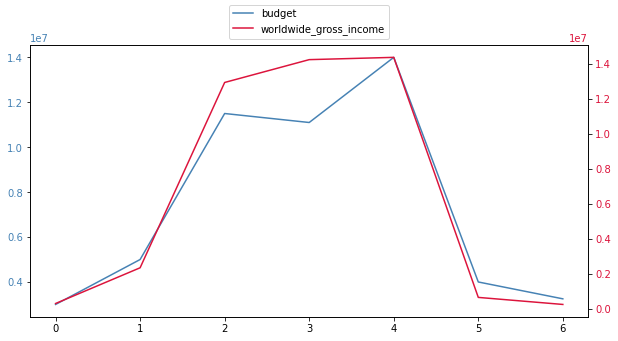

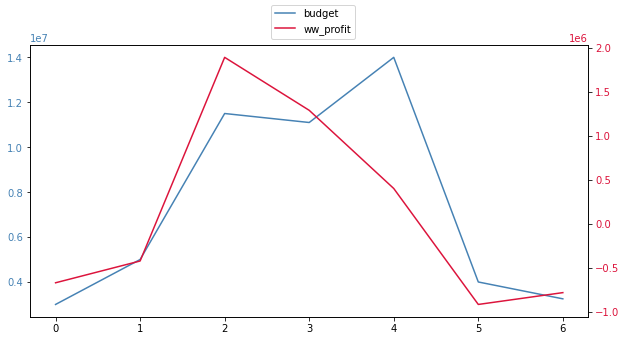

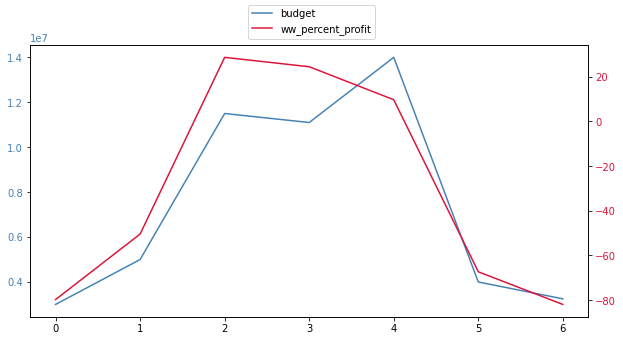

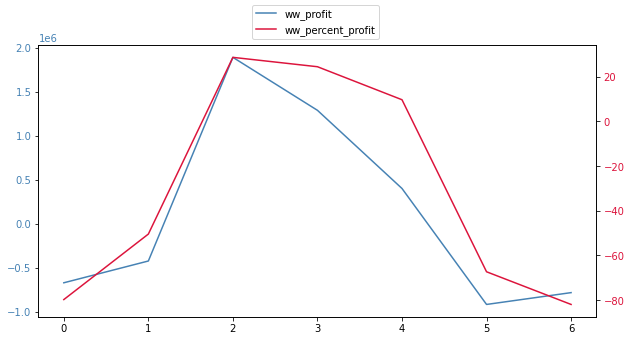

In [65]:
dual_plot_median(clean_df, 'publish_dayofweek', 'budget', 'worldwide_gross_income')
dual_plot_median(clean_df, 'publish_dayofweek', 'budget', 'ww_profit')
dual_plot_median(clean_df, 'publish_dayofweek', 'budget', 'ww_percent_profit')
dual_plot_median(clean_df, 'publish_dayofweek', 'ww_profit', 'ww_percent_profit')

In [66]:
clean_df.groupby('publish_dayofweek').agg({'budget':'median'}).sort_values(by='budget', ascending=False).head(5)

,budget
publish_dayofweek,
4,14000000.0
2,11500000.0
3,11100000.0
1,5000000.0
5,4000000.0


In [67]:
clean_df.groupby('publish_dayofweek').agg({'worldwide_gross_income':'median'})\
.sort_values(by='worldwide_gross_income', ascending=False).head(5)

,worldwide_gross_income
publish_dayofweek,
4,14374652.0
3,14243893.0
2,12937510.0
1,2332251.0
5,636796.0


In [68]:
clean_df.groupby('publish_dayofweek').agg({'ww_profit':'median'}).sort_values(by='ww_profit', ascending=False).head(5)

,ww_profit
publish_dayofweek,
2,1894358.0
3,1292560.5
4,404286.0
1,-419642.0
0,-667194.5


In [69]:
clean_df.groupby('publish_dayofweek').agg({'ww_percent_profit':'median'}).sort_values(by='ww_percent_profit', ascending=False).head(5)

,ww_percent_profit
publish_dayofweek,
2,28.674414
3,24.479305
4,9.705340
1,-50.415167
5,-67.291906


* Films with high budget tend to release on Friday, Wednesday, and Thursday respectively.
* Films with high profit tend to release on Wednesday, Thursday, and Friday respectively.
* Films wiith high percent profit tend to release on Wednesday, Thursday, and Friday respectively.

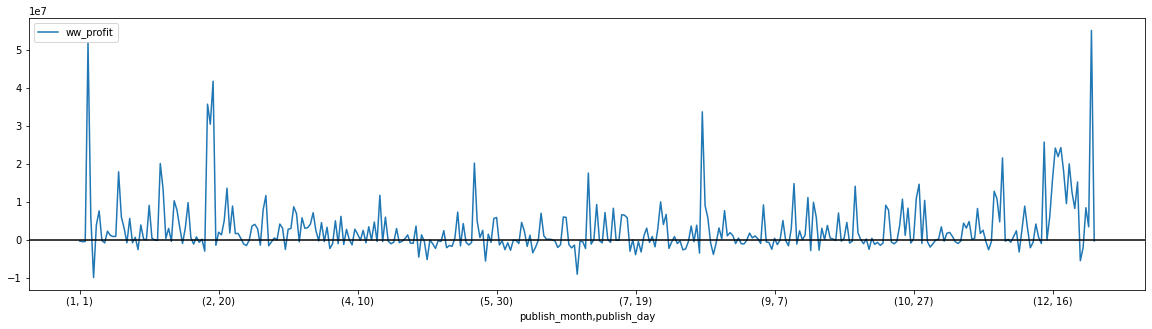

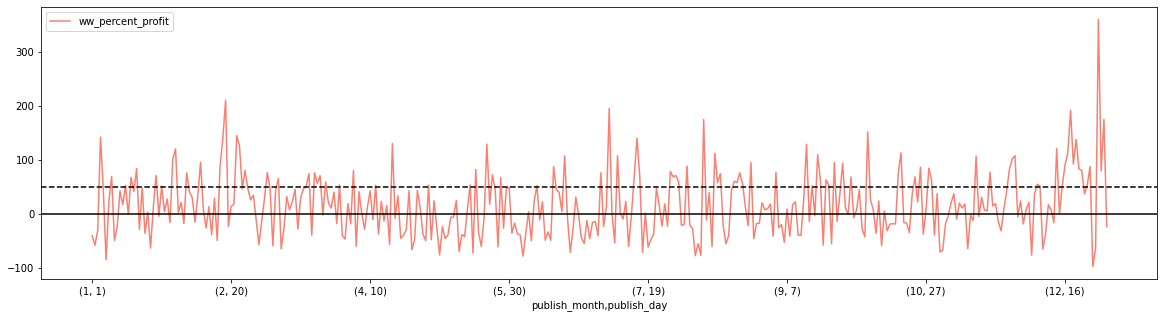

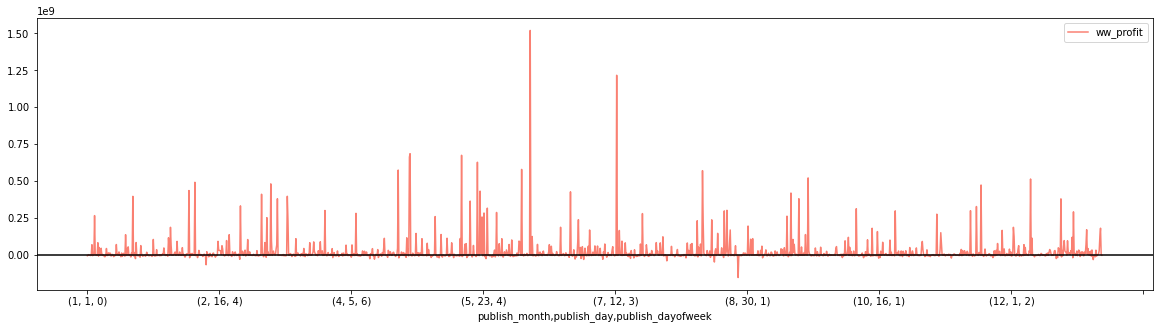

In [70]:
clean_df.groupby(['publish_month', 'publish_day']).agg({'ww_profit':'median'}).plot(figsize=(20,5))
plt.axhline(0, color='black')
clean_df.groupby(['publish_month', 'publish_day']).agg({'ww_percent_profit':'median'}).plot(figsize=(20,5), color='salmon')
plt.axhline(0, color='black')
plt.axhline(50, color='black', linestyle='--')

clean_df.groupby(['publish_month', 'publish_day', 'publish_dayofweek']).agg({'ww_profit':'median'})\
.plot(figsize=(20,5), color='salmon')
plt.axhline(0, color='black')

In [71]:
clean_df.groupby(['publish_month', 'publish_day']).agg({'budget':'median'})\
.sort_values(by='budget', ascending=False).head(5)

budget
publish_month publish_day            
1             4            36000000.0
2             29           33750000.0
12            22           30000000.0
              30           30000000.0
              19           30000000.0

In [72]:
clean_df.groupby(['publish_month', 'publish_day']).agg({'ww_profit':'median'}).sort_values(by='ww_profit', ascending=False).head(5)

ww_profit
publish_month publish_day            
12            30           55243411.0
1             4            52091915.0
2             18           41855648.0
              16           35797027.0
8             12           33782078.0

In [73]:
clean_df.groupby(['publish_month', 'publish_day']).agg({'ww_percent_profit':'median'}).sort_values(by='ww_percent_profit', ascending=False).head(5)

ww_percent_profit
publish_month publish_day                   
12            28                  361.190669
2             18                  211.358145
7             5                   195.556643
12            18                  191.964089
              30                  175.585593

## 2. How release date influence imdb score and metascore?

In [74]:
tmp = clean_df[(clean_df['avg_vote'] >= 5) & (clean_df['metascore'] >= 50)]

In [75]:
# print(clean_df['avg_vote'].mean(), clean_df['avg_vote'].median())
# print(clean_df['metascore'].mean(), clean_df['metascore'].median())

### Publish Year

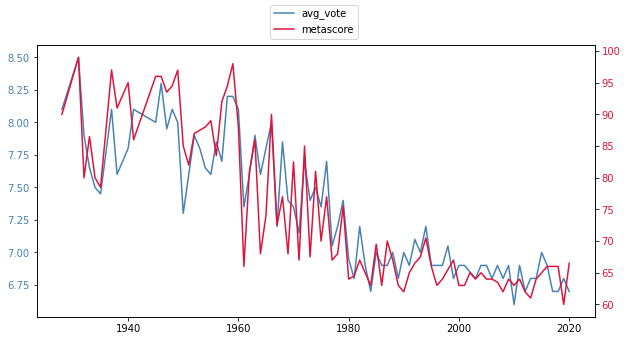

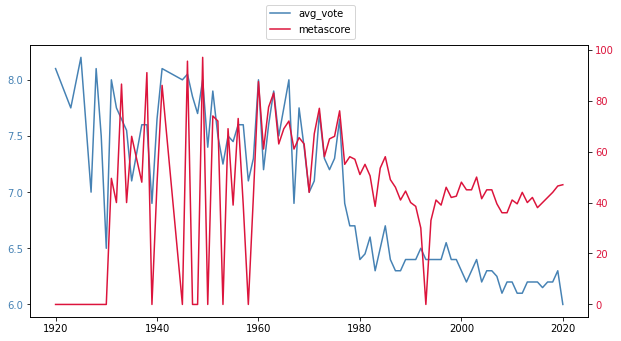

In [76]:
dual_plot_median(tmp, 'publish_year', 'avg_vote', 'metascore')
dual_plot_median(clean_df, 'publish_year', 'avg_vote', 'metascore')

### Release date(Month) and score

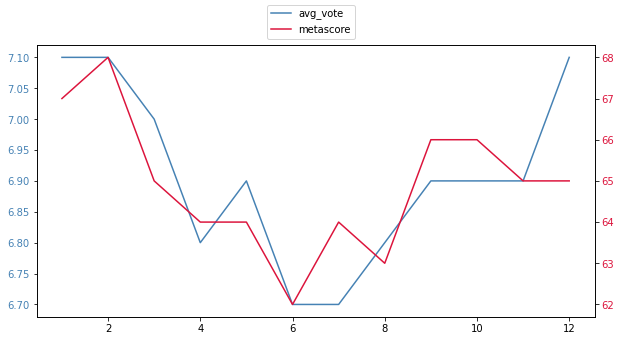

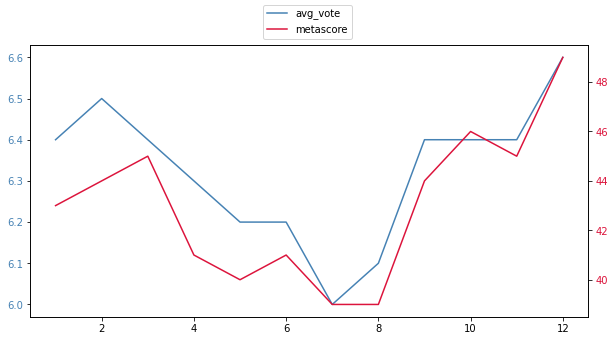

In [77]:
# Release date(Month) and score

# fig, ax1 = plt.subplots(figsize=(10,5))
# ax1.plot(tmp.groupby('publish_month').agg({'avg_vote':'median'}), color='steelblue')
# ax2 = ax1.twinx()
# ax2.plot(tmp.groupby('publish_month').agg({'metascore':'median'}), color='salmon')

dual_plot_median(tmp, 'publish_month', 'avg_vote', 'metascore')
dual_plot_median(clean_df, 'publish_month', 'avg_vote', 'metascore')

In [78]:
# IMDB score
clean_df.groupby('publish_month').agg({'avg_vote':'median'}).sort_values(by='avg_vote', ascending=False).head(5)

,avg_vote
publish_month,
12,6.6
2,6.5
1,6.4
3,6.4
9,6.4


In [79]:
# Metascore
clean_df.groupby('publish_month').agg({'metascore':'median'}).sort_values(by='metascore', ascending=False).head(5)

,metascore
publish_month,
12,49.0
10,46.0
3,45.0
11,45.0
2,44.0


* Films release in December, February, and January tend to get more imdb score respectively.
* Films release in December, February, and March tend to get more metascore respectively.

### Release date(Week) and score

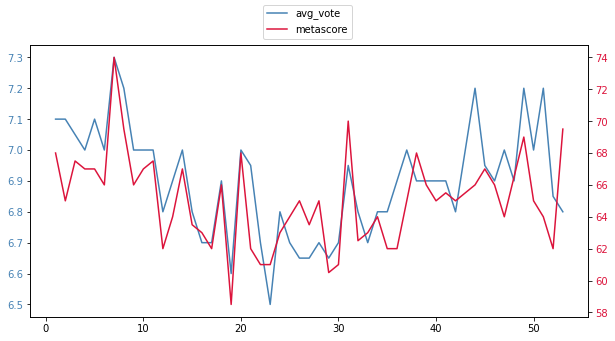

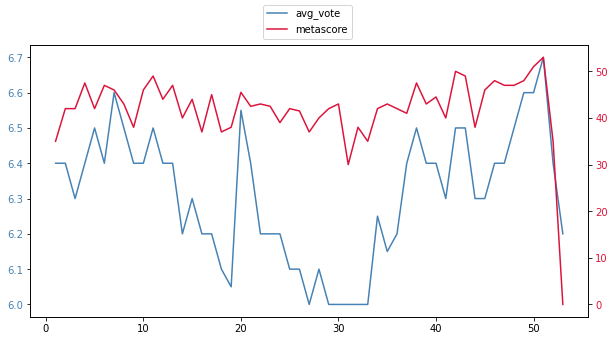

In [80]:
# Release date(Week) and score

dual_plot_median(tmp, 'publish_week', 'avg_vote', 'metascore')
dual_plot_median(clean_df, 'publish_week', 'avg_vote', 'metascore')

In [81]:
# IMDB score
clean_df.groupby('publish_week').agg({'avg_vote':'median'}).sort_values(by='avg_vote', ascending=False).head(5)

,avg_vote
publish_week,
51,6.70
49,6.60
50,6.60
7,6.60
20,6.55


In [82]:
# Metascore
clean_df.groupby('publish_week').agg({'metascore':'median'}).sort_values(by='metascore', ascending=False).head(5)

,metascore
publish_week,
51,53.0
50,51.0
42,50.0
43,49.0
11,49.0


* Films release in week number 51, 49, and 50 tend to get more imdb score respectively.
* Films release in week number 51, 50, and 42 tend to get more metascore respectively.

### Release date(Day) and score

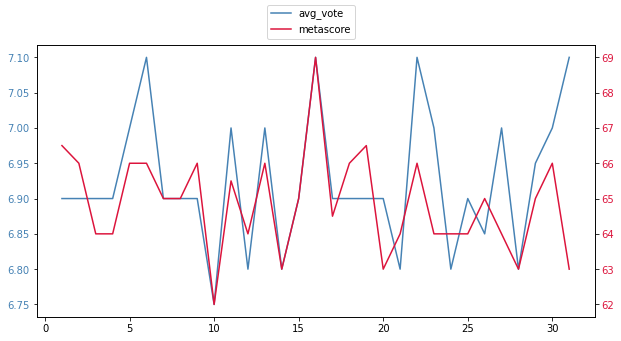

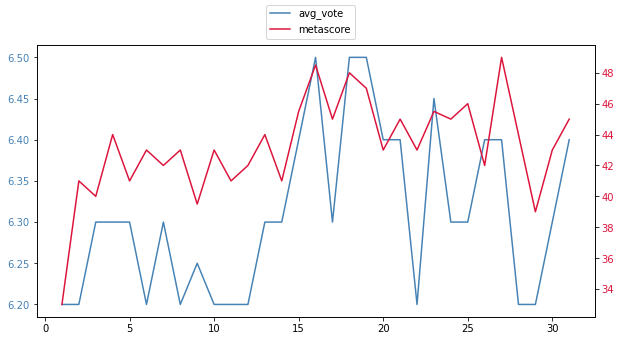

In [83]:
# Release date(Day) and score

dual_plot_median(tmp, 'publish_day', 'avg_vote', 'metascore')
dual_plot_median(clean_df, 'publish_day', 'avg_vote', 'metascore')

In [84]:
# IMDB score
clean_df.groupby('publish_day').agg({'avg_vote':'median'}).sort_values(by='avg_vote', ascending=False).head(5)

,avg_vote
publish_day,
16,6.50
19,6.50
18,6.50
23,6.45
15,6.40


In [85]:
# Metascore
clean_df.groupby('publish_day').agg({'metascore':'median'}).sort_values(by='metascore', ascending=False).head(5)

,metascore
publish_day,
27,49.0
16,48.5
18,48.0
19,47.0
25,46.0


* Films release on date 16, 19, and 18 tend to get more imdb score respectively.
* Films release on date 27, 16, and 18 tend to get more metascore respectively.

### Release date(Day of week) and score

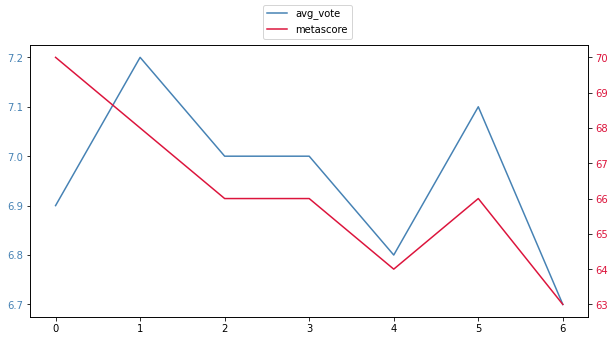

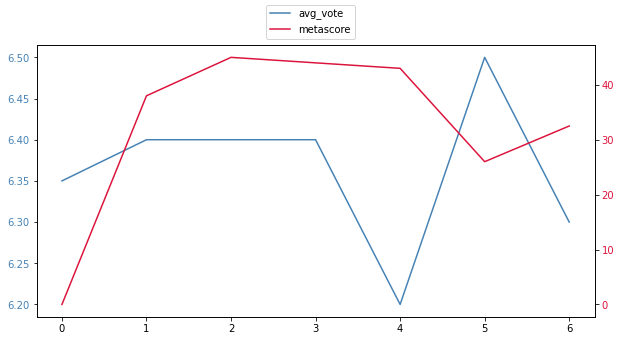

In [86]:
# Release date(Day of week) and score
dual_plot_median(tmp, 'publish_dayofweek', 'avg_vote', 'metascore')
dual_plot_median(clean_df, 'publish_dayofweek', 'avg_vote', 'metascore')

In [87]:
# IMDB score
clean_df.groupby('publish_dayofweek').agg({'avg_vote':'median'}).sort_values(by='avg_vote', ascending=False).head(5)

,avg_vote
publish_dayofweek,
5,6.50
1,6.40
2,6.40
3,6.40
0,6.35


In [88]:
# Metascore
clean_df.groupby('publish_dayofweek').agg({'metascore':'median'}).sort_values(by='metascore', ascending=False).head(5)

,metascore
publish_dayofweek,
2,45.0
3,44.0
4,43.0
1,38.0
6,32.5


* Films release on Saturday, Tuesday, and Wednesday tend to get more imdb score respectively.
* Films release on Wednesday, Thursday, and Friday tend to get more metascore respectively.

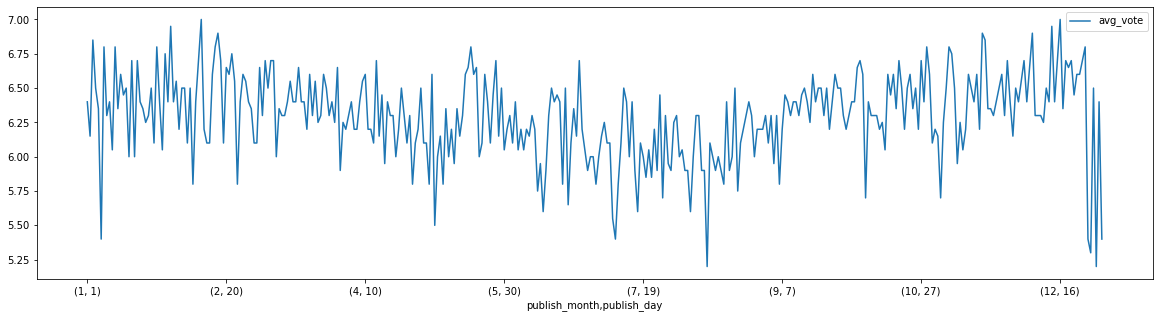

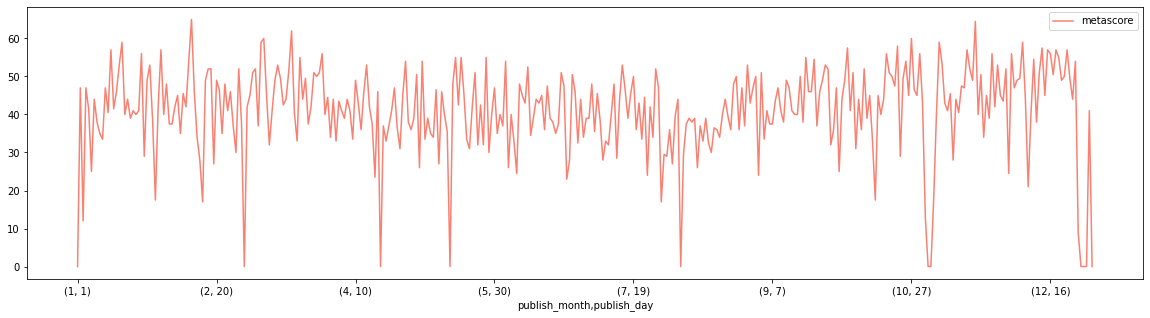

In [89]:
clean_df.groupby(['publish_month', 'publish_day']).agg({'avg_vote':'median'}).plot(figsize=(20,5))
# plt.axhline(0, color='black')
clean_df.groupby(['publish_month', 'publish_day']).agg({'metascore':'median'}).plot(figsize=(20,5), color='salmon')
# plt.axhline(0, color='black')
# plt.axhline(50, color='black', linestyle='--')

In [90]:
clean_df.groupby(['publish_month', 'publish_day']).agg({'avg_vote':'median'})\
.sort_values(by='avg_vote', ascending=False).head(5)

,,avg_vote
publish_month,publish_day,
12,16,7.00
2,11,7.00
12,13,6.95
1,31,6.95
2,17,6.90


In [91]:
clean_df.groupby(['publish_month', 'publish_day']).agg({'metascore':'median'})\
.sort_values(by='metascore', ascending=False).head(5)

,,metascore
publish_month,publish_day,
2,11,65.0
11,19,64.5
3,18,62.0
10,27,60.0
3,8,60.0


* Films release on 16th December tend to get more imdb score respectively.
* Films release on 11th February tend to get more metascore respectively.

## 3. How release date releated to genre? // How genre influence release date?

ref: https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe/48454871

In [92]:
tmp = clean_df.groupby(['publish_month', 'genre_1']).agg({'title':'count'})\
.sort_values(by=['publish_month','title'], ascending=[True,False])\
.reset_index()
tmp['rank'] = tmp.groupby(by='publish_month')['title'].transform(lambda x: x.rank(ascending=False))
tmp = tmp[tmp['rank'] <= 10]
tmp = tmp.loc[:, ['publish_month','genre_1','title']]
tmp = tmp.set_index('publish_month')
tmp_pivot = tmp.pivot(columns='genre_1')
tmp_pivot

title                      ...                         
genre_1       Action Adventure Animation  ... Romance Thriller Western
publish_month                             ...                         
1              174.0      41.0      26.0  ...     NaN      NaN     NaN
2              151.0      34.0      31.0  ...     NaN      NaN     NaN
3              164.0      47.0      31.0  ...     NaN      4.0     NaN
4              194.0      46.0      35.0  ...     NaN      NaN     NaN
5              167.0      26.0      19.0  ...     NaN      4.0     NaN
6              159.0      27.0      27.0  ...     NaN      NaN     NaN
7              149.0      37.0      18.0  ...     2.0      NaN     NaN
8              197.0      42.0      32.0  ...     NaN      NaN     NaN
9              221.0      37.0      41.0  ...     NaN      5.0     NaN
10             189.0      42.0      51.0  ...     NaN      7.0     NaN
11             150.0      38.0      42.0  ...     NaN      NaN     NaN
12             147.0      56.0      78.0  ...     NaN      NaN     4.0

[12 rows x 15 columns]

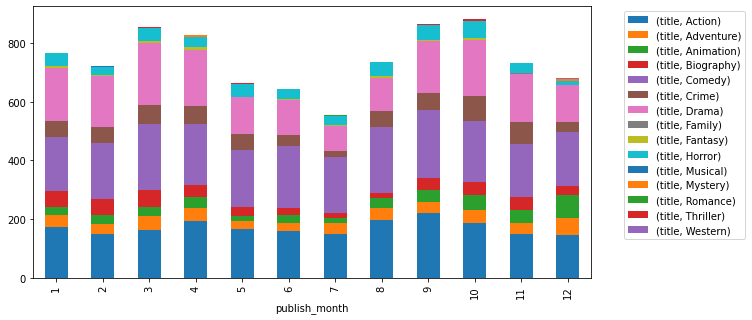

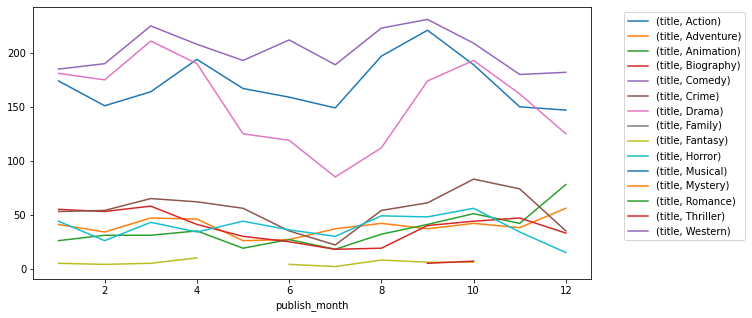

In [93]:
tmp_pivot.plot(kind='bar', stacked = True, figsize=(10,5))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
tmp_pivot.plot(kind='line', figsize=(10,5))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

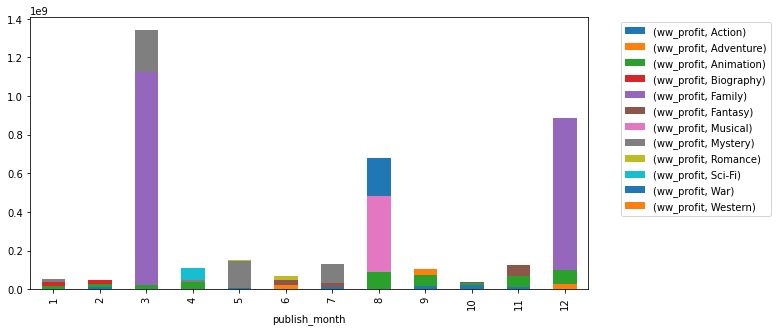

In [94]:
tmp = clean_df.groupby(['publish_month', 'genre_1']).agg({'ww_profit':'median'})\
.sort_values(by=['publish_month','ww_profit'], ascending=[True,False])\
.reset_index()

tmp['rank'] = tmp.groupby(by='publish_month')['ww_profit'].transform(lambda x: x.rank(ascending=False))
tmp = tmp[tmp['rank'] <= 3]
tmp = tmp.loc[:, ['publish_month','genre_1','ww_profit']]
tmp = tmp.set_index('publish_month')
tmp

tmp_pivot = tmp.pivot(columns='genre_1')
tmp_pivot

tmp_pivot.plot(kind='bar', stacked = True, figsize=(10,5))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
# tmp_pivot.plot(kind='line', figsize=(10,5))
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [95]:
tmp_pivot

ww_profit              ...                         
genre_1            Action   Adventure  ...          War     Western
publish_month                          ...                         
1                     NaN         NaN  ...          NaN         NaN
2              11122105.0         NaN  ...          NaN         NaN
3                     NaN         NaN  ...          NaN         NaN
4                     NaN         NaN  ...          NaN         NaN
5               4068039.0         NaN  ...          NaN         NaN
6                     NaN  21429330.0  ...          NaN         NaN
7              10707966.0         NaN  ...          NaN         NaN
8                     NaN         NaN  ...  197207347.0         NaN
9              14316248.0         NaN  ...          NaN  28100000.0
10             19244626.0         NaN  ...          NaN         NaN
11             12419912.0         NaN  ...          NaN         NaN
12                    NaN  28747729.0  ...          NaN         NaN

[12 rows x 12 columns]

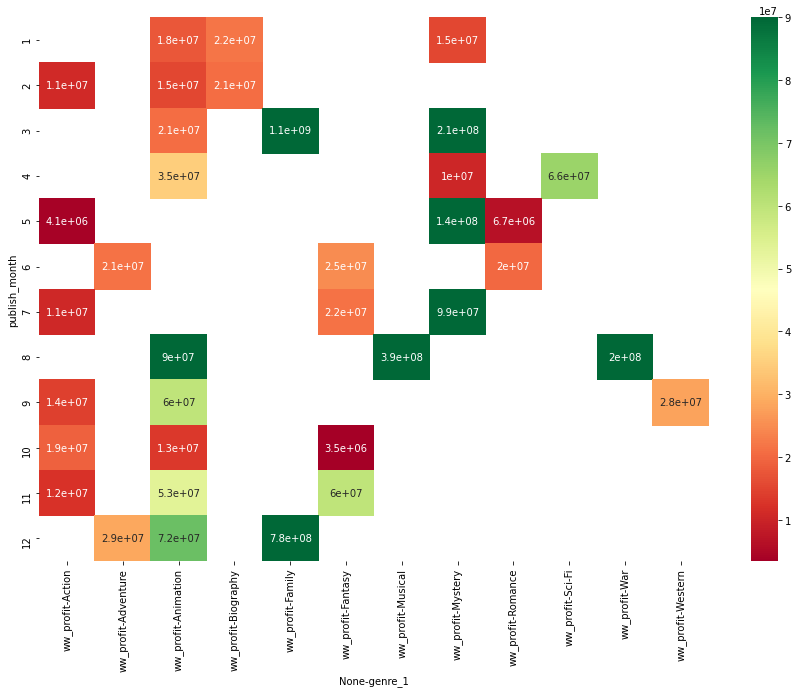

In [96]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data=tmp_pivot, cmap='RdYlGn', vmax=0.9e+08, annot=True, ax=ax)